### Reinforcement Learning-based Image Captioning with R-LSTM

In [2]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.image_utils import image_from_url

from torchsummary import summary
from keybert import KeyBERT

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


import metrics

Working on:  cpu


### Load MS-COCO data
Using the Microsoft COCO dataset for captioning.

In [3]:
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions_lens <class 'numpy.ndarray'> (400135,) float64
val_captions_lens <class 'numpy.ndarray'> (195954,) float64


In [4]:
small_data = load_coco_data(max_train=50000)

### Policy Network

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(PolicyNetwork, self).__init__()
        
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        
        vocab_size = len(word_to_idx)

        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        
        self.cnn2linear = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim, batch_first=True)
        self.linear2vocab = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, features, captions):
        input_captions = self.caption_embedding(captions)
        hidden_init = self.cnn2linear(features)
        cell_init = torch.zeros_like(hidden_init)
        output, _ = self.lstm(input_captions, (hidden_init, cell_init))
        output = self.linear2vocab(output)
        return output

### Reward Network

In [6]:
class RewardNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(RewardNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = torch.zeros(1, 1, self.hidden_dim).to(device)
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.gru = nn.GRU(wordvec_dim, hidden_dim)
    
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.gru(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class RewardNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(RewardNetwork, self).__init__()
        self.rewrnn = RewardNetworkRNN(word_to_idx)
        self.visual_embed = nn.Linear(512, 512)
        self.semantic_embed = nn.Linear(512, 512)
        
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            rrnn = self.rewrnn(captions[:, t])
        rrnn = rrnn.squeeze(0).squeeze(1)
        se = self.semantic_embed(rrnn)
        ve = self.visual_embed(features)
        return ve, se

### Value Network

In [7]:
class ValueNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(ValueNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_dim).to(device), torch.zeros(1, 1, self.hidden_dim).to(device))
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim)
        
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.lstm(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class ValueNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(ValueNetwork, self).__init__()
        self.valrnn = ValueNetworkRNN(word_to_idx)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 1)
    
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            vrnn = self.valrnn(captions[:, t])
        vrnn = vrnn.squeeze(0).squeeze(1)
        state = torch.cat((features, vrnn), dim=1)
        output = self.linear1(state)
        output = self.linear2(output)
        return output

### Generating Captions

In [8]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('policyNetwork.pt'))
policyNet.train(mode=False)

valueNet = ValueNetwork(data["word_to_idx"]).to(device)
valueNet.load_state_dict(torch.load('valueNetwork.pt'))
valueNet.train(mode=False)

ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

#### Greedy Caption Generator

In [9]:
def GenerateCaptions(features, captions, model):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    for t in range(max_seq_len-1):
        output = model(features, gen_caps)
        gen_caps = torch.cat((gen_caps, output[:, -1:, :].argmax(axis=2)), axis=1)
    return gen_caps

#### Beam Search Caption Generator

In [10]:
def GenerateCaptionsWithBeamSearch(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                score = candidates[c][1] - torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates 

#### Lookahead Inference with Policy and Value Network

In [11]:
def GenerateCaptionsWithBeamSearchValueScoring(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                value = valueNet(features.squeeze(0), cap).detach()
                score = candidates[c][1] - 0.6*value.item() -0.4*torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates   

[[ -1.2303767   -4.806963     8.533777   ...   0.28401917  -0.04026076
   -0.25601593]
 [ 15.976098    -7.3382072   -7.347663   ...  -0.33290958  -0.96845496
    1.6827646 ]
 [-22.686117    16.412437     0.4373119  ...  -0.89508474  -0.11228228
   -1.2711093 ]
 ...
 [ 31.565493    11.678165    20.492212   ...  -0.31051296  -0.7093524
   -0.58677226]
 [ 17.475239    18.201956   -17.278948   ...   0.8789816   -0.21191888
   -1.2044929 ]
 [ -3.914217    -7.0956974  -12.596421   ...  -1.0031083    0.36291438
   -2.407761  ]]
http://farm1.staticflickr.com/22/25535574_f2347f2ff7_z.jpg
<START> a man and a woman in a room with a <UNK> <UNK> <END>
[('unk', 0.314), ('room', 0.2973), ('woman', 0.2703), ('man', 0.1953)]
URL Error:  Gone http://farm4.staticflickr.com/3662/3639047570_1c0cc2b782_z.jpg
http://farm4.staticflickr.com/3662/3639047570_1c0cc2b782_z.jpg
<START> a street sign on top of a city street <END>
[('street', 0.5512), ('city', 0.49), ('sign', 0.4394)]
http://farm5.staticflickr.com/40

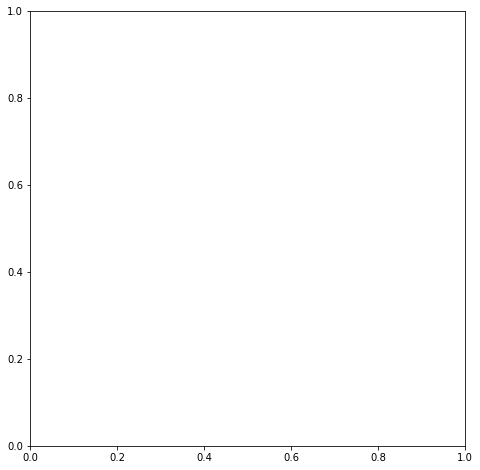

In [12]:
k_m = KeyBERT()
with torch.no_grad():
    max_seq_len = 17
    captions, features, urls = sample_coco_minibatch(small_data, batch_size=100, split='val')
    print(features)
    for i in range(10):
        gen_caps = []
        gen_caps.append(GenerateCaptions(features[i:i+1], captions[i:i+1], policyNet)[0])
        gen_caps.append(GenerateCaptionsWithBeamSearch(features[i:i+1], captions[i:i+1], policyNet)[0][0][0])
        gen_caps.append(GenerateCaptionsWithBeamSearchValueScoring(features[i:i+1], captions[i:i+1], policyNet)[0][0][0])
        decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])

#         f = open("truth3.txt", "a")
#         f.write(decoded_tru_caps + "\n")
#         f.close()
        
#         decoded_gen_caps = decode_captions(gen_caps[0], data["idx_to_word"])
#         f = open("greedy3.txt", "a")
#         f.write(decoded_gen_caps + "\n")
#         f.close()
        
#         decoded_gen_caps = decode_captions(gen_caps[1], data["idx_to_word"])
#         f = open("beam3.txt", "a")
#         f.write(decoded_gen_caps + "\n")
#         f.close()
        
#         decoded_gen_caps = decode_captions(gen_caps[2], data["idx_to_word"])
#         f = open("policyvalue3.txt", "a")
#         f.write(decoded_gen_caps + "\n")
#         f.close()
        try:
            plt.imshow(image_from_url(urls[i]))
            plt.show()
        except:
            pass
        keyword = k_m.extract_keywords(decode_captions(gen_caps[2], data["idx_to_word"]).replace("<START>","").replace("<END>",""))
        print(urls[i])
        print(decode_captions(gen_caps[2], data["idx_to_word"]))
        print(keyword)

### Caption Evaluation

In [14]:
def BLEU_score(gt_caption, sample_caption, w):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [w])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [15]:
caps0 = []
caps1 = []
caps2 = []
caps3 = []
f = open("results/truth3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps0.append(x)
f = open("results/greedy3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps1.append(x)
f = open("results/beam3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps2.append(x)
f = open("results/policyvalue3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps3.append(x)

In [16]:
b1, b2, b3 = 0, 0, 0
for w in range(1, 5):
    for i in range(len(caps0)):
        b1 += BLEU_score(caps0[i], caps1[i], w)
        b2 += BLEU_score(caps0[i], caps2[i], w)
        b3 += BLEU_score(caps0[i], caps3[i], w)
    b1 /= len(caps0)
    b2 /= len(caps0)
    b3 /= len(caps0)
    print("Greedy BLEU-" + str(w), ":", b1)
    print("Beam BLEU-" + str(w), ":", b2)
    print("Agent BLEU-" + str(w), ":", b3)
    print()

Greedy BLEU-1 : 0.24624043997583175
Beam BLEU-1 : 0.2540224578441918
Agent BLEU-1 : 0.2563426767182271

Greedy BLEU-2 : 0.09065434672351722
Beam BLEU-2 : 0.0902509189133115
Agent BLEU-2 : 0.09155483470073025

Greedy BLEU-3 : 0.039722450216904244
Beam BLEU-3 : 0.037689433253779
Agent BLEU-3 : 0.03852101647793212

Greedy BLEU-4 : 0.019965843321998366
Beam BLEU-4 : 0.017952085683363046
Agent BLEU-4 : 0.018542079795694805



In [16]:
ref, hypo = metrics.load_textfiles(caps0, caps3)
print(metrics.score(ref, hypo))

The number of references is 1000
{'Bleu_1': 0.2727798112116863, 'Bleu_2': 0.13207907633440683, 'Bleu_3': 0.0704492797131235, 'Bleu_4': 0.03961546368562404, 'ROUGE_L': 0.2611785262449472}


### Training the Policy Network

In [17]:
pretrained = True

policyNetwork = PolicyNetwork(data["word_to_idx"]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(policyNetwork.parameters(), lr=0.0001)


if pretrained:
    policyNetwork.load_state_dict(torch.load('models/policyNetwork.pt'))  

In [20]:
batch_size = 100
bestLoss = 50
#0.006700546946376562

for epoch in range(250000, 251000):
    print(epoch)
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    captions_in = torch.tensor(captions[:, :-1], device=device).long()
    captions_ou = torch.tensor(captions[:, 1:], device=device).long()
    output = policyNetwork(features, captions_in)
    
    loss = 0
    for i in range(batch_size):
        caplen = np.nonzero(captions[i] == 2)[0][0] + 1
        loss += (caplen/batch_size)*criterion(output[i][:caplen], captions_ou[i][:caplen])
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(policyNetwork.state_dict(), "policyNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

250000
epoch: 250000 loss: 46.593292236328125
250001
250002
250003
epoch: 250003 loss: 46.031776428222656
250004
250005
250006
250007
250008
250009
250010
250011
250012
250013
250014
epoch: 250014 loss: 45.665836334228516
250015
250016
250017
250018
250019
250020
250021
250022
250023
250024
250025
250026
epoch: 250026 loss: 45.38121032714844
250027
250028
250029
250030
250031
epoch: 250031 loss: 45.21809768676758
250032
250033
250034
250035
250036
epoch: 250036 loss: 44.29335021972656
250037
250038
250039
250040
250041
250042
250043
250044
250045
250046
250047
250048
250049
250050
250051
250052
250053
250054
250055
250056
epoch: 250056 loss: 44.239627838134766
250057
250058
250059
250060
250061
250062
epoch: 250062 loss: 43.287105560302734
250063
250064
250065
250066
250067
250068
250069
250070
250071
250072
250073
250074
250075
250076
250077
250078
250079
250080
250081
250082
250083
250084
250085
250086
250087
250088
250089
250090
250091
250092
250093
250094
250095
250096
epoch: 25009

### Training the Reward Network

In [18]:
rewardNetwork = RewardNetwork(data["word_to_idx"]).to(device)
optimizer = optim.Adam(rewardNetwork.parameters(), lr=0.001)

# https://cs230-stanford.github.io/pytorch-nlp.html#writing-a-custom-loss-function
def VisualSemanticEmbeddingLoss(visuals, semantics):
    beta = 0.2
    N, D = visuals.shape
    
    visloss = torch.mm(visuals, semantics.t())
    visloss = visloss - torch.diag(visloss).unsqueeze(1)
    visloss = visloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    visloss = F.relu(visloss)
    visloss = torch.sum(visloss)/N
    
    semloss = torch.mm(semantics, visuals.t())
    semloss = semloss - torch.diag(semloss).unsqueeze(1)
    semloss = semloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    semloss = F.relu(semloss)
    semloss = torch.sum(semloss)/N
    
    return visloss + semloss        

In [22]:
batch_size = 50
bestLoss = 10000

for epoch in range(1000):
    print(epoch)
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    captions = torch.tensor(captions, device=device).long()
    ve, se = rewardNetwork(features, captions)
    loss = VisualSemanticEmbeddingLoss(ve, se)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(rewardNetwork.state_dict(), "rewardNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rewardNetwork.rewrnn.hidden_cell.detach_()

0
epoch: 0 loss: 251.90911865234375
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
epoch: 127 loss: 247.28048706054688
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
epoch: 232 loss: 238.68353271484375
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


In [19]:
def GetRewards(features, captions, model):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1) 
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1) 
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards

In [20]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
rewardNet.load_state_dict(torch.load('rewardNetwork.pt'))
for param in rewardNet.parameters():
    param.require_grad = False
print(rewardNet)

policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('policyNetwork.pt'))
for param in policyNet.parameters():
    param.require_grad = False
print(policyNet)

valueNetwork = ValueNetwork(data["word_to_idx"]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(valueNetwork.parameters(), lr=0.0001)
valueNetwork.train(mode=True)

RewardNetwork(
  (rewrnn): RewardNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (gru): GRU(512, 512)
  )
  (visual_embed): Linear(in_features=512, out_features=512, bias=True)
  (semantic_embed): Linear(in_features=512, out_features=512, bias=True)
)
PolicyNetwork(
  (caption_embedding): Embedding(1004, 512)
  (cnn2linear): Linear(in_features=512, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear2vocab): Linear(in_features=512, out_features=1004, bias=True)
)


ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [25]:
batch_size = 50
bestLoss = 10000
max_seq_len = 17

for epoch in range(1000):
    print(epoch)
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    
    # Generate captions using the policy network
    captions = GenerateCaptions(features, captions, policyNet)
    
    # Compute the reward of the generated caption using reward network
    rewards = GetRewards(features, captions, rewardNet)
    
    # Compute the value of a random state in the generation process
#     print(features.shape, captions[:, :random.randint(1, 17)].shape)
    values = valueNetwork(features, captions[:, :random.randint(1, 17)])
    
    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(valueNetwork.state_dict(), "valueNetwork.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()
    rewardNet.rewrnn.hidden_cell.detach_()

0


c:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch: 0 loss: 0.2978333532810211
1
2
epoch: 2 loss: 0.24407081305980682
3
4
5
epoch: 5 loss: 0.2090148776769638
6
7
epoch: 7 loss: 0.1365364044904709
8
epoch: 8 loss: 0.11033648252487183
9
10
11
12
13
epoch: 13 loss: 0.08113570511341095
14
15
16
17
18
epoch: 18 loss: 0.07739177346229553
19
epoch: 19 loss: 0.06010852009057999
20
epoch: 20 loss: 0.055811185389757156
21
epoch: 21 loss: 0.048952627927064896
22
23
24
epoch: 24 loss: 0.03812519460916519
25
26
27
28
29
30
epoch: 30 loss: 0.03199620544910431
31
epoch: 31 loss: 0.030315712094306946
32
33
34
35
36
37
38
39
40
epoch: 40 loss: 0.02730732224881649
41
42
43
44
epoch: 44 loss: 0.026722168549895287
45
46
epoch: 46 loss: 0.01963929831981659
47
48
49
50
51
epoch: 51 loss: 0.012558701448142529
52
53
54
55
56
57
58
59
60
epoch: 60 loss: 0.012210254557430744
61
epoch: 61 loss: 0.011992527171969414
62
63
64
epoch: 64 loss: 0.011972343549132347
65
66
67
68
69
70
epoch: 70 loss: 0.011026845313608646
71
epoch: 71 loss: 0.009631924331188202
72

KeyboardInterrupt: 

## Reinforcement Learning
Advantage Actor Critic Model for Reinforcement Learning

In [21]:
class AdvantageActorCriticNetwork(nn.Module):
    def __init__(self, valueNet, policyNet):
        super(AdvantageActorCriticNetwork, self).__init__()

        self.valueNet = valueNet #RewardNetwork(data["word_to_idx"]).to(device)
        self.policyNet = policyNet #PolicyNetwork(data["word_to_idx"]).to(device)

    def forward(self, features, captions):
        # Get value from value network
        values = self.valueNet(features, captions)
        # Get action probabilities from policy network
        probs = self.policyNet(features.unsqueeze(0), captions)[:, -1:, :]        
        return values, probs 

In [22]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
valueNet = ValueNetwork(data["word_to_idx"]).to(device)

rewardNet.load_state_dict(torch.load('rewardNetwork.pt'))
policyNet.load_state_dict(torch.load('policyNetwork.pt'))
valueNet.load_state_dict(torch.load('valueNetwork.pt'))

a2cNetwork = AdvantageActorCriticNetwork(valueNet, policyNet)
optimizer = optim.Adam(a2cNetwork.parameters(), lr=0.0001)

### Curriculum Learning

In [23]:
curriculum = [2, 4, 6, 8, 10, 12, 14, 16]
episodes = 20

small_data = load_coco_data(max_train=50000)

for level in curriculum:
    
    for epoch in range(100):        
        episodicAvgLoss = 0
        
        captions, features, _ = sample_coco_minibatch(small_data, batch_size=episodes, split='train')
        features = torch.tensor(features, device=device).float()
        captions = torch.tensor(captions, device=device).long()

        for episode in range(episodes):
            log_probs = []
            values = []
            rewards = []
            caplen = np.nonzero(captions[episode] == 2)[0][0] + 1
            
            if (caplen - level > 1):
                captions_in = captions[episode:episode+1, :caplen-level]
                features_in = features[episode:episode+1]

                for step in range(level):
                    value, probs = a2cNetwork(features_in, captions_in)
                    probs = F.softmax(probs, dim=2)
                    
                    dist = probs.cpu().detach().numpy()[0,0]
                    action = np.random.choice(probs.shape[-1], p=dist)
                    
                    gen_cap = torch.from_numpy(np.array([action])).unsqueeze(0).to(device)
                    captions_in = torch.cat((captions_in, gen_cap), axis=1)
                    
                    log_prob = torch.log(probs[0, 0, action])
                    
                    reward = GetRewards(features_in, captions_in, rewardNet)
                    reward = reward.cpu().detach().numpy()[0, 0]
                    
                    rewards.append(reward)
                    values.append(value)
                    log_probs.append(log_prob)
                    
            values = torch.FloatTensor(values).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            log_probs = torch.stack(log_probs).to(device)
            
            advantage = values - rewards 
            actorLoss = (-log_probs * advantage).mean()
            criticLoss = 0.5 * advantage.pow(2).mean()
            
            loss = actorLoss + criticLoss
            episodicAvgLoss += loss.item()/episodes
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(epoch, ":", episodicAvgLoss)

c:\Users\asus\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:57: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  return bound(*args, **kwds)


0 : -0.007387125713285064
1 : 0.04488514754921198
2 : -0.06401610735338181
3 : 0.05547436216729692
4 : -0.003837803754140631
5 : 0.03098210810130695
6 : -0.0022535616502864313
7 : -0.06710768283810466
8 : -0.05291894957190377
9 : -0.010877899546176208
10 : -0.0625397466123104
11 : -0.01266534309834242
12 : -0.014296415238641206
13 : -0.10871602222323418
14 : -0.054213504854124045
15 : 0.07687334474176168
16 : -0.04758633135352283
17 : 0.02093416415154934
18 : -0.02663892600685358
19 : -0.04710544722620399
20 : 0.009828876378014686
21 : 0.04300703879562207
22 : -0.0007733814098173767
23 : -0.052076150616630915
24 : -0.014234895121899169
25 : -0.07356770869228058
26 : 0.00901621376397088
27 : -0.03975281740713398
28 : 0.016795617592288183
29 : -0.0014798063450143673
30 : -0.022788259154185656
31 : -0.04661788479425013
32 : -0.003521186858415604
33 : -0.02608041261555627
34 : 0.051183212338946765
35 : 0.002820358256576583
36 : 0.014380510864430108
37 : 0.006490728957578544
38 : -0.0492351